# Module 5 Project - Data Cleaning Notebook

TV Commercial Classification Dataset

# Dataset

The Feature File is represented in Lib SVM data format (The Files are arranged channel wise) and contains approximately 62% commercial instances( Positives). Dimension index for different Features are as Follows

Labels : +1/-1 ( Commercials/Non Commercials) 

Feature
Dimension Index in feature File
- 1 - Shot Length
- 2,3 - Motion Distribution( Mean and Variance)
- 4,5 - Frame Difference Distribution ( Mean and Variance)
- 6,7 - Short time energy ( Mean and Variance)
- 8,9 - ZCR( Mean and Variance)
- 10,11 - Spectral Centroid ( Mean and Variance)
- 12,13 - Spectral Roll off ( Mean and Variance)
- 14,15 - Spectral Flux ( Mean and Variance)
- 16,17 - Fundamental Frequency ( Mean and Variance)
- 18-58 - Motion Distribution ( 40 bins)
- 59-91 - Frame Difference Distribution ( 32 bins)
- 92-122 - Text area distribution (  15 bins Mean  and 15 bins for variance )
- 123-4123 - Bag of Audio Words ( 4000 bins)
- 4124-4125 - Edge change Ratio ( Mean and Variance)

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2

#MY FUNCTIONS
from cf_matrix import make_confusion_matrix
from mod5project_functions import plot_histograms

import pickle #For saving cleaned dataframe to use later

# Import Data & Clean

In [2]:
#filenames = ['BBC.txt','CNN.txt','CNNIBN.txt','NDTV.txt','TIMESNOW.txt']
filenames = ['BBC.txt','CNN.txt']

In [3]:
data = []
for file in filenames:
    with open("data/"+file) as f:
        for line in f:
            line_data={}
            values = line.split()
            target = int(values.pop(0))
            if target != 1:
                target = 0
            line_data['target'] = target
            for value in values:
                key, val = value.split(':')
                line_data[int(key)] = float(val)
            data.append(line_data)

df = pd.DataFrame(data)
y = df.target
df = df.drop(columns=['target']).sort_index(axis=1)
df.columns = df.columns.map(str)
df['target'] = y
df.shape

(40265, 232)

In [4]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,959,1002,1016,1028,1048,1112,1119,4124,4125,target
0,123.0,1.316440,1.516003,5.605905,5.346760,0.013233,0.010729,0.091743,0.050768,3808.067871,...,0.036017,0.006356,0.008475,NaN,0.002119,NaN,NaN,0.422334,0.663918,1
1,124.0,0.966079,0.546420,4.046537,3.190973,0.008338,0.011490,0.075504,0.065841,3466.266113,...,0.117647,0.006303,NaN,NaN,0.008403,NaN,NaN,0.332664,0.766184,1
2,109.0,2.035407,0.571643,9.551406,5.803685,0.015189,0.014294,0.094209,0.044991,3798.196533,...,0.062500,0.004808,NaN,NaN,0.009615,NaN,NaN,0.346674,0.225022,1
3,86.0,3.206008,0.786326,10.092709,2.693058,0.013962,0.011039,0.092042,0.043756,3761.712402,...,0.046296,0.012346,NaN,NaN,0.012346,0.003086,NaN,0.993323,0.840083,1
4,76.0,3.135861,0.896346,10.348035,2.651010,0.020914,0.012061,0.108018,0.052617,3784.488037,...,NaN,0.003521,NaN,NaN,0.045775,0.007042,NaN,0.341520,0.710470,1


### Fill NAN values in bag of words bins

Fill with zero as zero represents non-presence of word

In [5]:
#Fill with zero as zero represents non-presence of word
bag_of_words_columns = df.columns[118:-3]  #column strings 123-4123
print("Columms:\n",bag_of_words_columns)
for col in bag_of_words_columns:
    df[col].fillna(value=0,inplace=True)

Columms:
 Index(['123', '125', '127', '128', '129', '130', '131', '134', '137', '141',
       ...
       '882', '886', '924', '959', '1002', '1016', '1028', '1048', '1112',
       '1119'],
      dtype='object', length=111)


### Fill NAN values in text area distribution bins

#Fill with zero as zero represents non-presence of text in bin

In [6]:
#Fill with zero as zero represents non-presence of text in bin
#text_area_cols = df.columns[88:118] #column strings 90-119 - 30bins
text_area_cols = df.columns[90:118] #column strings 90-119 - 30bins
print("Columns:\n",text_area_cols)
for col in text_area_cols:
    df[col].fillna(value=0,inplace=True)

Columns:
 Index(['92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
       '103', '104', '105', '106', '107', '108', '109', '110', '111', '112',
       '113', '114', '115', '116', '117', '118', '119'],
      dtype='object')


### Drop remaining columns that are over 25% NAN

5 columns dropped

In [7]:
#drop columns with over 25% missing data
threshold = 0.75*len(df)
cols_to_drop = df.columns[df.count()<threshold]
print("Columns to drop:\n",cols_to_drop)
df.drop(columns=cols_to_drop,inplace=True)
df.shape

Columns to drop:
 Index(['84', '85', '86', '87', '88', '90', '91'], dtype='object')


(40265, 225)

### Remove features representing Motion Distribution bins and Frame Difference Distribution bins

This data is already being represented in columns: 

4,5 Frame Difference Distribution (Mean and Var)

6,7 Motion Distribution (Mean and Var)

In [8]:
bin_cols_to_drop = df.columns[17:83]   #columns 18-89
print("Columns to drop:\n",bin_cols_to_drop)
df.drop(columns=bin_cols_to_drop,inplace=True)
df.shape

Columns to drop:
 Index(['18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '79', '80', '81', '82', '83'],
      dtype='object')


(40265, 159)

## View Correlations

### All features

Text(0.5, 1.0, 'Heatmap of Correlations between all fields')

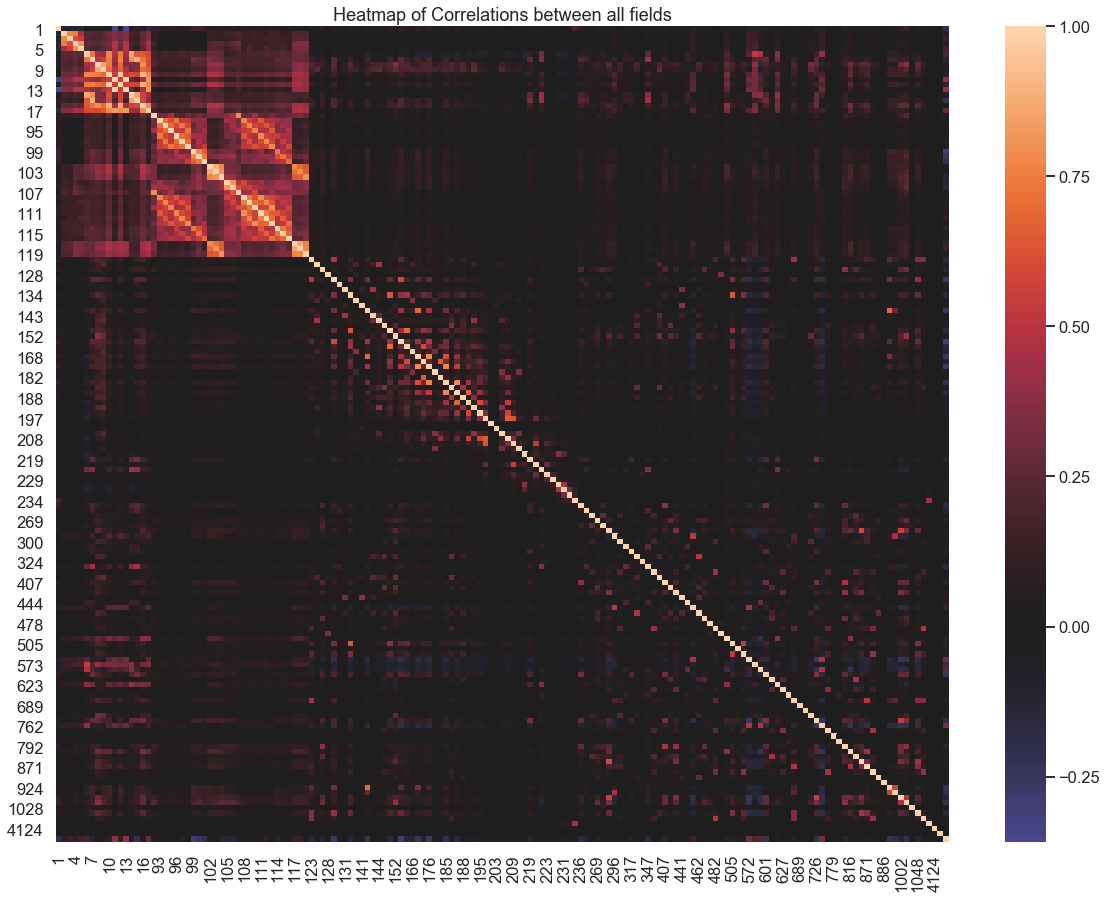

In [9]:
correlations = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(correlations, center=0)
plt.title("Heatmap of Correlations between all fields")

### Video & Audio Signal Correlations Only

Text(0.5, 1.0, 'Heatmap of Correlations between Raw Video & Audio Features')

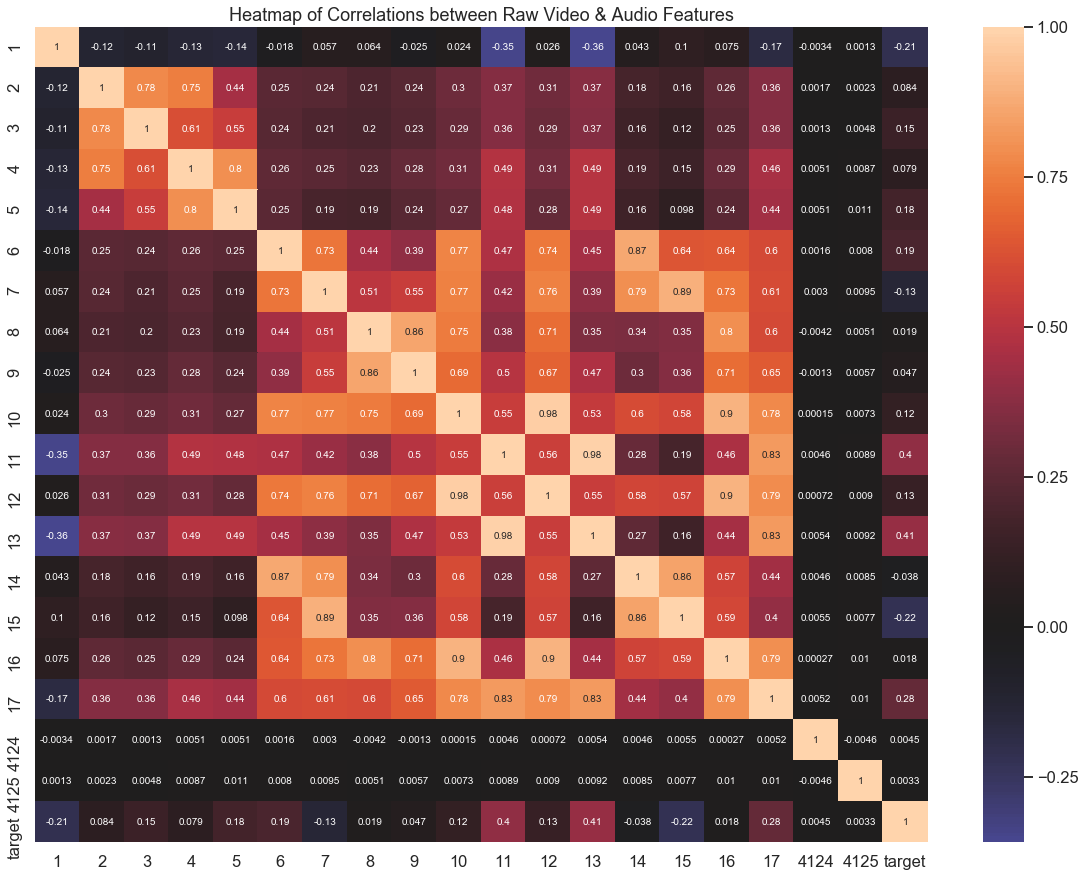

In [10]:
#Correlations
cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '4124', '4125', 'target']
corr = df[cols].corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True, center=0)
plt.title("Heatmap of Correlations between Raw Video & Audio Features")

### Text area distribution Correlations

Text(0.5, 1.0, 'Heatmap of Correlations between Text Area Features')

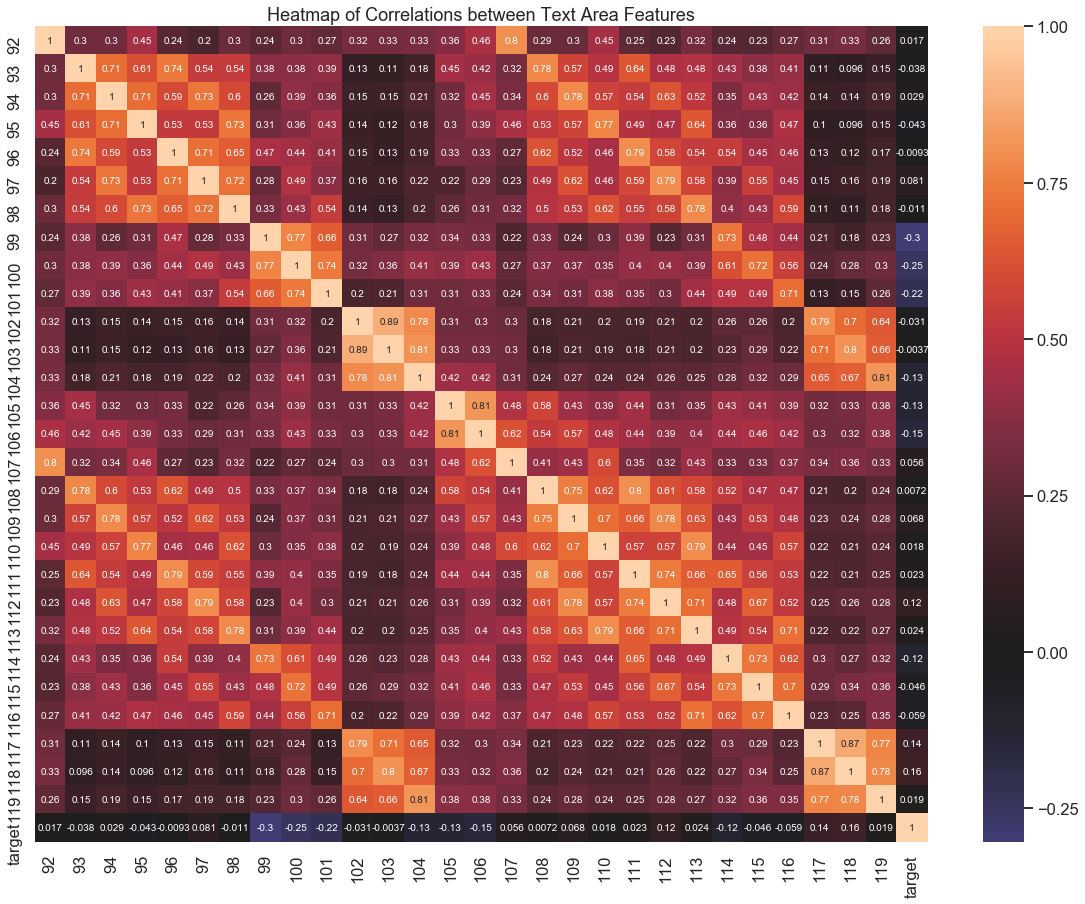

In [11]:
cols = list(text_area_cols)
cols.append('target')
text_area_correlations = df[cols].corr()
plt.figure(figsize=(20,15))
sns.heatmap(text_area_correlations, annot=True, center=0)
plt.title("Heatmap of Correlations between Text Area Features")

### Bag of Words feature Correlations

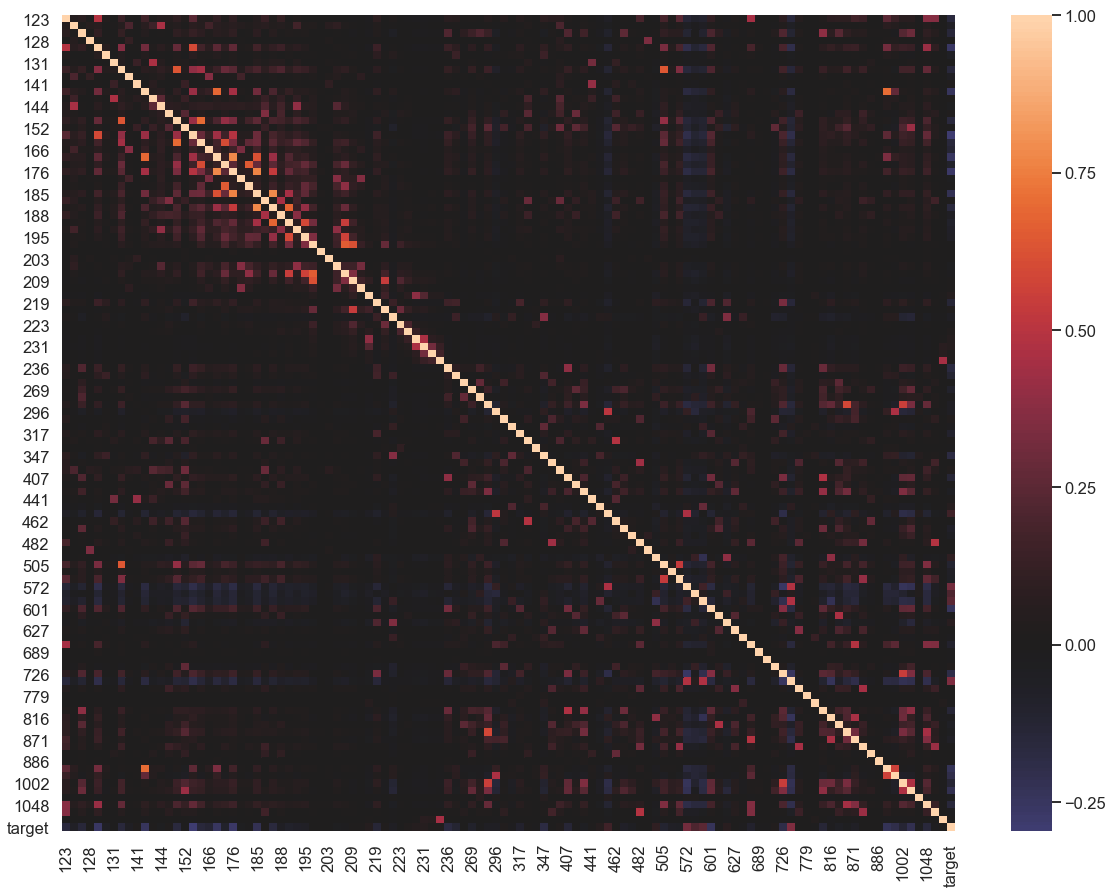

In [12]:
cols = list(bag_of_words_columns)
cols.append('target')
text_area_correlations = df[cols].corr()
plt.figure(figsize=(20,15))
sns.heatmap(text_area_correlations, annot=False, center=0)

# Inspect Histograms

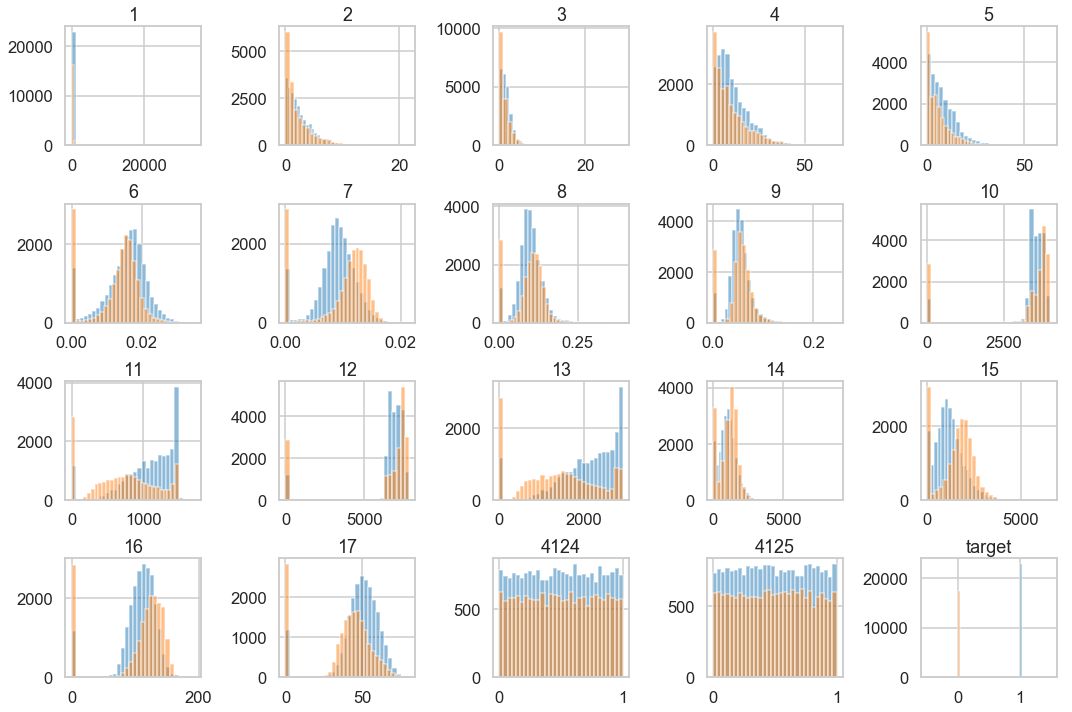

In [13]:
cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '4124', '4125', 'target']
plot_histograms(df,column_names=cols,nrows=4,ncols=5)

### Drop Some Outliers based on histograms

In [14]:
#Remove very long clip lengths (don't make up much of the data)
print(len(df[df['1']>=1000])) #104 records>=2000, 537 records>=1000
df.drop(index=df[df['1']>=1000].index, inplace=True)

537


In [15]:
#Dropping data where audio amplitude variation is equal to zero - outliers
print(len(df[df['6']==0]))  #additional 3961 records
df.drop(index=df[df['6']==0].index, inplace=True)

3961


In [16]:
print(len(df[df['10']<2000]))    #additional 217 records
df.drop(index=df[df['10']<2000].index, inplace=True)

217


### View updated histograms after data cleaning

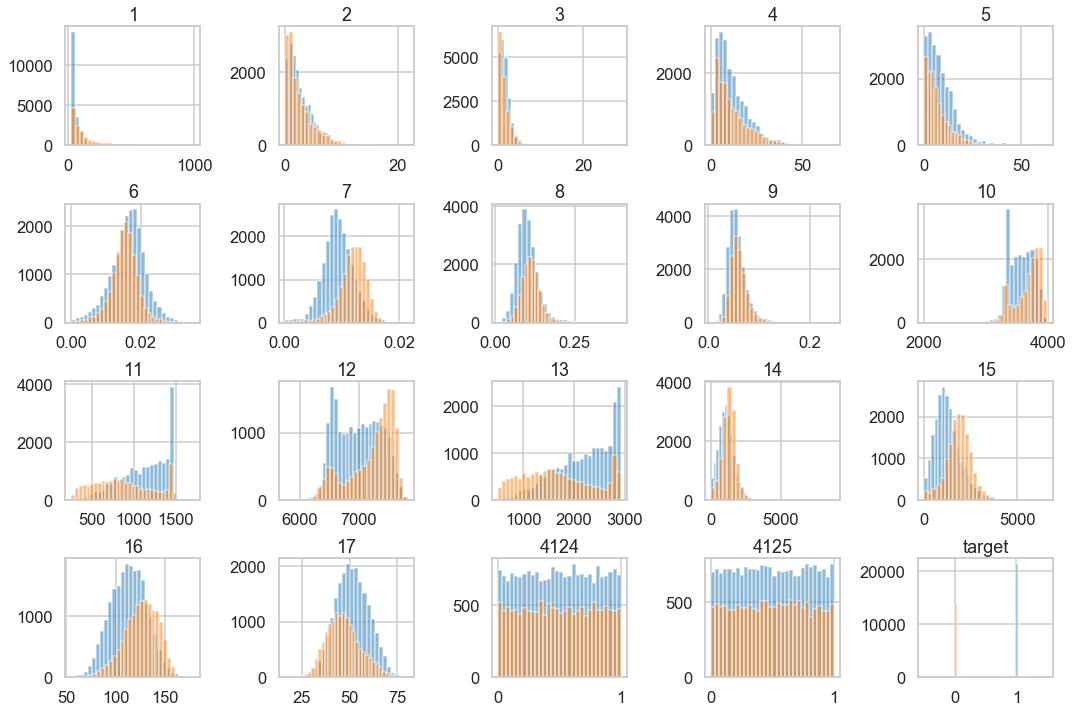

In [17]:
plot_histograms(df,column_names=cols,nrows=4,ncols=5)

**Features that have some distinctness with distribution of targets:**
4, 7, 10, 11, 12, 13, 14, 15, 16, 17

In [18]:
y.value_counts()

1    22827
0    17438
Name: target, dtype: int64

# Save Cleaned Dataset for other Notebooks

In [19]:
#Pickle the cleaned dataset
with open("df.pickle","wb") as f:
    pickle.dump(df,f,pickle.HIGHEST_PROTOCOL)

## Set Feature and Target Dataframes and Scale Features

In [20]:
X = df.drop(columns=['target'])
y = df.target

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

# KBest

In [21]:
kbest = SelectKBest(chi2, k=15)
kbest.fit(X,y)
cols = kbest.get_support(indices=True)
zipped = zip(df.columns[cols], kbest.scores_[cols])
sorted(zipped,key=lambda x: x[1], reverse=True)

[('15', 2105222.565350956),
 ('13', 1187284.2544613327),
 ('1', 773453.6135029269),
 ('11', 585104.531608335),
 ('14', 269237.2660796591),
 ('12', 67177.04541808565),
 ('10', 42379.29702714051),
 ('16', 12033.066250976495),
 ('17', 3390.6116626515322),
 ('5', 3002.2187672063637),
 ('99', 1044.4137274561078),
 ('100', 830.7324016953723),
 ('762', 545.9390691048616),
 ('101', 543.0556706980002),
 ('572', 405.579454988111)]

In [22]:
kbest = SelectKBest(f_classif, k=15)
kbest.fit(X,y)
cols = kbest.get_support(indices=True)
zipped = zip(df.columns[cols], kbest.scores_[cols])
sorted(zipped,key=lambda x: x[1], reverse=True)

[('7', 8061.114052094556),
 ('15', 6811.887941537124),
 ('11', 6520.082489028194),
 ('13', 6484.607603485465),
 ('99', 6023.758631205644),
 ('1', 5125.305225439918),
 ('16', 4639.659424290181),
 ('156', 4610.903282212975),
 ('762', 4262.914928134377),
 ('100', 4200.165345215222),
 ('176', 3625.6651773849976),
 ('129', 3590.3549252998823),
 ('572', 3409.960082602056),
 ('10', 3362.309299299528),
 ('12', 3355.0710739171154)]

## OTHER HISTOGRAMS

For the many other features in this dataset

In [23]:
#motion_dist_cols = df.columns[17:57]
#print(motion_dist_cols)
#plot_histograms(df,motion_dist_cols,nrows=9,ncols=5,figsize=(15,20))

In [24]:
#frame_diff_cols = df.columns[57:86]
#print(frame_diff_cols)
#plot_histograms(df,frame_diff_cols,nrows=7,ncols=5,figsize=(15,20));

In [25]:
text_area_cols = df.columns[17:45]
text_area_cols

Index(['92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
       '103', '104', '105', '106', '107', '108', '109', '110', '111', '112',
       '113', '114', '115', '116', '117', '118', '119'],
      dtype='object')

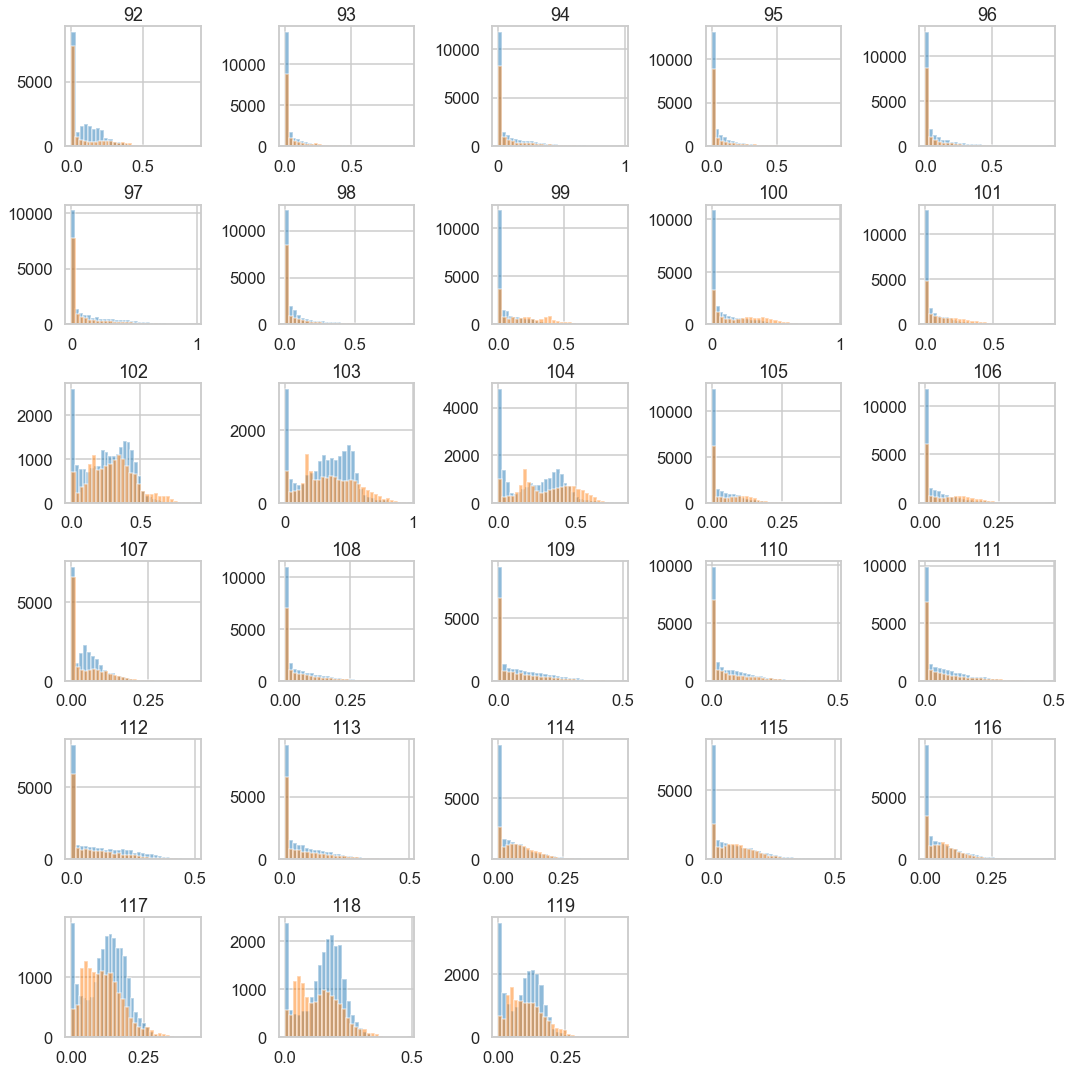

In [26]:
plot_histograms(df,text_area_cols,nrows=6,ncols=5,figsize=(15,15));

In [27]:
bag_of_words_columns = df.columns[45:156]
print(len(bag_of_words_columns))
bag_of_words_columns

111


Index(['123', '125', '127', '128', '129', '130', '131', '134', '137', '141',
       ...
       '882', '886', '924', '959', '1002', '1016', '1028', '1048', '1112',
       '1119'],
      dtype='object', length=111)

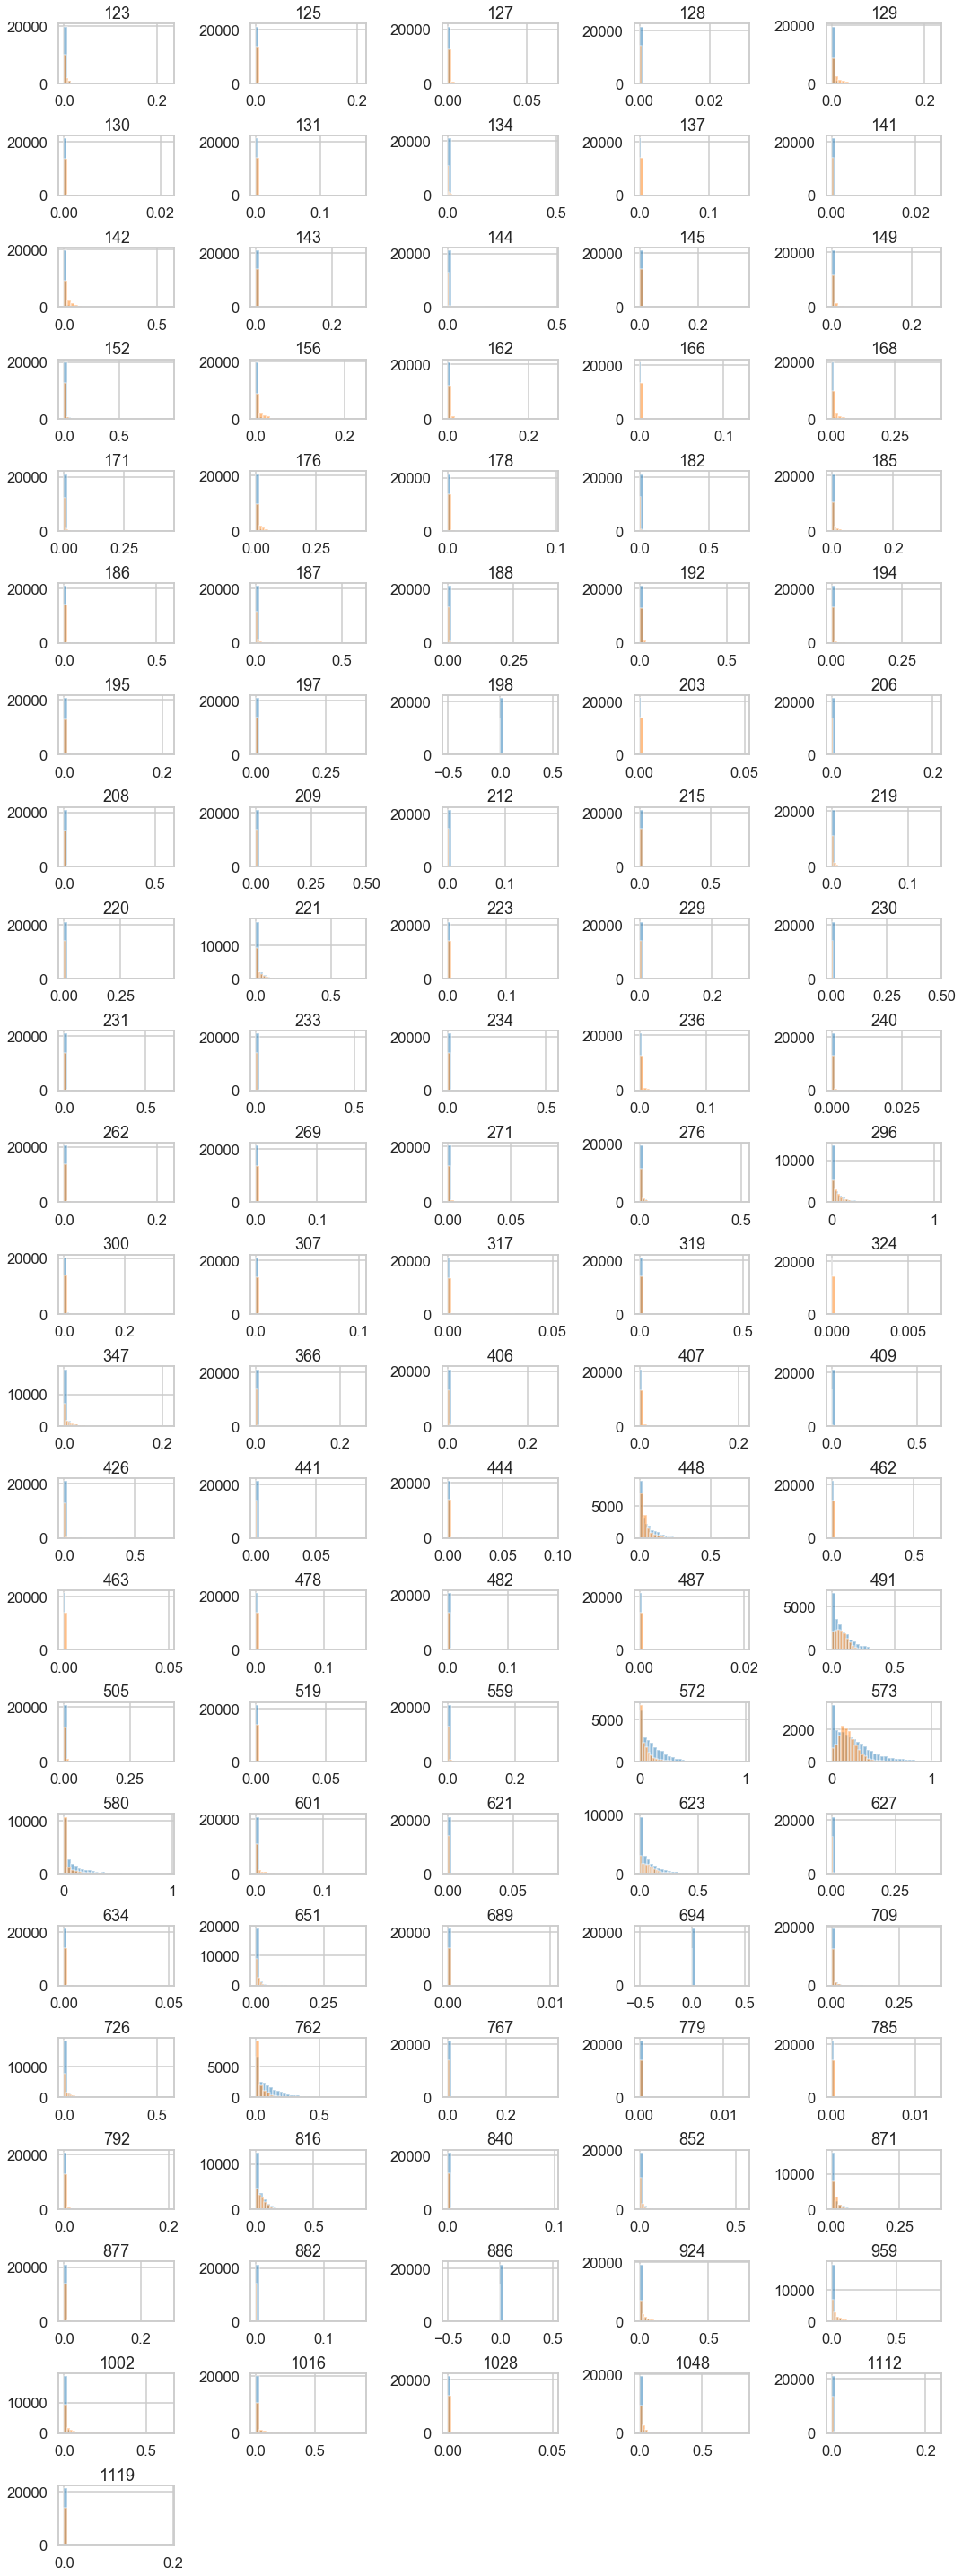

In [28]:
plot_histograms(df,bag_of_words_columns,nrows=23,ncols=5,figsize=(15,40));